# FIN3080 Assignment 5

> **Author Information**:
>- Name: `Weiyuan Xu`
>- StdID: `120090888`

> **Reference**:
>- Bernard, Victor L and Jacob K Thomas (1989). “Post-earnings-announcement drift: delayed price response or risk premium?” In: Journal of Accounting research 27, pp. 1–36.

> **Data Resources**:
>- Data Service Platform: `CSMAR`

## 0. Preparations

### 0-1. Load in packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
import statsmodels.api as sm

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

## 1. Step 1: EPS Data Processing

### Step 1.1 - 1.2: Extract the EPS data from CSMAR

***Market Type Extraction***
- Main Board: Using filtering function of CSMAR to remain the records of SSE Main Board-Listed A Shares and Shenzhen Main Board-Listed A Shares

***Statement Type Filtering***

When accessing data from CSMAR, we set the condition "Statement Type = Consolidated Statements" since:

Consolidated statements reflect the financial position and operating results of the entire enterprise group; The parent statement only reflects the business situation of the parent company, and its right to control the entire enterprise group is actually reflected in the long-term asset account as an investment. In the process of merging the statements of the parent company and the subsidiary company, the parent company's investment in the subsidiary company, internal purchase and sale, creditor's rights and debts are offset.

In [2]:
df_EPS = pd.read_csv('step1_1&2.csv')

In [3]:
df_EPS = df_EPS.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "F090101B": "EPS"})
df_EPS = df_EPS.loc[:,["Stock_Code", "ShortName_EN", "Date", "EPS"]]
df_EPS.head()

,Stock_Code,ShortName_EN,Date,EPS
0,1,PAYH,2013-03-31,0.700566
1,1,PAYH,2013-06-30,0.918751
2,1,PAYH,2013-09-30,1.426863
3,1,PAYH,2013-12-31,1.599727
4,1,PAYH,2014-03-31,0.530827


### Step 1.3: Keep semi-annual and annual reports

Convert the quarterly records into the semi-annual records.

In [4]:
df_EPS = df_EPS.loc[(df_EPS["Date"].str.endswith('06-30')) | (df_EPS["Date"].str.endswith('12-31'))]
df_EPS.head()

,Stock_Code,ShortName_EN,Date,EPS
1,1,PAYH,2013-06-30,0.918751
3,1,PAYH,2013-12-31,1.599727
5,1,PAYH,2014-06-30,0.881575
7,1,PAYH,2014-12-31,1.733217
9,1,PAYH,2015-06-30,0.809630


Replace EPS over the second half of each year as the difference between EPS as of Q4 and Q2 in that year.

In [5]:
df_EPS['Date'] = pd.to_datetime(df_EPS['Date'])
df_grouped = df_EPS.groupby(['Stock_Code', df_EPS['Date'].dt.year])
df_diff = df_grouped['EPS'].diff(periods = 1)
df_EPS.loc[df_diff.notnull(), 'EPS'] = df_diff[df_diff.notnull()]
df_EPS.head()

,Stock_Code,ShortName_EN,Date,EPS
1,1,PAYH,2013-06-30,0.918751
3,1,PAYH,2013-12-31,0.680976
5,1,PAYH,2014-06-30,0.881575
7,1,PAYH,2014-12-31,0.851642
9,1,PAYH,2015-06-30,0.809630


### Step 1.4: Derive unexpected earnings

The unexpected earning for company i at time t is given by:

$$ UE_{i,t} = EPS_{i,t} - EPS_{i,t-2} $$

In [6]:
df_EPS['EPSi,t-2'] = df_EPS.groupby('Stock_Code')['EPS'].shift(2)
df_EPS['UE'] = df_EPS['EPS'] - df_EPS['EPSi,t-2']
df_EPS = df_EPS.drop('EPSi,t-2', axis = 1)
df_EPS = df_EPS.dropna()
df_EPS.head()

,Stock_Code,ShortName_EN,Date,EPS,UE
5,1,PAYH,2014-06-30,0.881575,-0.037176
7,1,PAYH,2014-12-31,0.851642,0.170666
9,1,PAYH,2015-06-30,0.809630,-0.071945
11,1,PAYH,2015-12-31,0.718429,-0.133213
13,1,PAYH,2016-06-30,0.715900,-0.093730


### Step 1.5: Derive standardize unexpected earnings

The standardize unexpected earning for company i at time t is give by:

$$ SUE_{i,t} = UE_{i,t} / \sigma_{i,t} $$

in which $\sigma_{i,t}$ is the standard deviation of {$UE_{i,t-3}$, $UE_{i,t-2}$, $UE_{i,t-1}$, $UE_{i,t}$}

In [7]:
df_EPS['sigma'] = df_EPS.groupby('Stock_Code')['UE'].rolling(window = 4).std().reset_index(0, drop = True)
df_EPS['SUE'] = df_EPS['UE'] / df_EPS['sigma']
df_EPS = df_EPS.dropna()
df_EPS.head(10)

,Stock_Code,ShortName_EN,Date,EPS,UE,sigma,SUE
11,1,PAYH,2015-12-31,0.718429,-0.133213,0.131842,-1.010402
13,1,PAYH,2016-06-30,0.715900,-0.093730,0.137506,-0.681643
15,1,PAYH,2016-12-31,0.600291,-0.118138,0.026994,-4.376467
17,1,PAYH,2017-06-30,0.731159,0.015259,0.067144,0.227259
19,1,PAYH,2017-12-31,0.619394,0.019103,0.071793,0.266086
21,1,PAYH,2018-06-30,0.778800,0.047641,0.074157,0.642438
23,1,PAYH,2018-12-31,0.666628,0.047234,0.017540,2.692971
25,1,PAYH,2019-06-30,0.897088,0.118288,0.042312,2.795639
27,1,PAYH,2019-12-31,0.555813,-0.110815,0.096874,-1.143904
29,1,PAYH,2020-06-30,0.704834,-0.192254,0.142285,-1.351192


### Step 1.6: Derive SUE deciles for firms by accounting dates

In [8]:
grouped = df_EPS.groupby('Date')
for group_name, group_data in grouped:
    if len(group_data) > 0:
        deciles = pd.qcut(group_data['SUE'], q = 10, labels = False) + 1
        df_EPS.loc[group_data.index, 'SUE_Decile'] = deciles
df_EPS

,Stock_Code,ShortName_EN,Date,EPS,UE,sigma,SUE,SUE_Decile
11,1,PAYH,2015-12-31,0.718429,-0.133213,0.131842,-1.010402,4.0
13,1,PAYH,2016-06-30,0.715900,-0.093730,0.137506,-0.681643,3.0
15,1,PAYH,2016-12-31,0.600291,-0.118138,0.026994,-4.376467,1.0
17,1,PAYH,2017-06-30,0.731159,0.015259,0.067144,0.227259,6.0
19,1,PAYH,2017-12-31,0.619394,0.019103,0.071793,0.266086,6.0
...,...,...,...,...,...,...,...,...
110933,605589,SQJT,2022-12-31,0.469120,0.104428,0.448919,0.232621,7.0
110941,605598,SHGW,2022-06-30,0.652245,0.266772,0.569260,0.468629,8.0
110943,605598,SHGW,2022-12-31,0.255409,0.285794,0.625149,0.457161,7.0
110951,605599,CBGF,2022-06-30,0.320246,0.040698,0.193258,0.210588,7.0


### Step 1.7 - 1.8: Merge announcement dates to the EPS data set on accounting dates and stock codes

Acquire the statement announcement dates.

In [9]:
df_AnnouncementDate = pd.read_csv('step1_7.csv')

In [10]:
df_AnnouncementDate = df_AnnouncementDate.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "Annodt": "Announcement_Date"})
df_AnnouncementDate = df_AnnouncementDate.loc[:,["Stock_Code", "Date", "Announcement_Date"]]
df_AnnouncementDate

,Stock_Code,Date,Announcement_Date
0,1,2013-03-31,2013-04-24
1,1,2013-06-30,2013-08-23
2,1,2013-09-30,2013-10-23
3,1,2013-12-31,2014-03-07
4,1,2014-03-31,2014-04-24
...,...,...,...
106351,605599,2021-12-31,2022-04-27
106352,605599,2022-03-31,2022-04-27
106353,605599,2022-06-30,2022-08-30
106354,605599,2022-09-30,2022-10-28


Merge two datasets.

In [11]:
df_AnnouncementDate['Date'] = pd.to_datetime(df_AnnouncementDate['Date'])
df_EPS_AnnouncementDate = pd.merge(df_EPS, df_AnnouncementDate, on = ['Stock_Code', 'Date'], how = 'left')
df_EPS_AnnouncementDate

,Stock_Code,ShortName_EN,Date,EPS,UE,sigma,SUE,SUE_Decile,Announcement_Date
0,1,PAYH,2015-12-31,0.718429,-0.133213,0.131842,-1.010402,4.0,2016-03-10
1,1,PAYH,2016-06-30,0.715900,-0.093730,0.137506,-0.681643,3.0,2016-08-12
2,1,PAYH,2016-12-31,0.600291,-0.118138,0.026994,-4.376467,1.0,2017-03-17
3,1,PAYH,2017-06-30,0.731159,0.015259,0.067144,0.227259,6.0,2017-08-11
4,1,PAYH,2017-12-31,0.619394,0.019103,0.071793,0.266086,6.0,2018-03-15
...,...,...,...,...,...,...,...,...,...
40960,605589,SQJT,2022-12-31,0.469120,0.104428,0.448919,0.232621,7.0,2023-04-11
40961,605598,SHGW,2022-06-30,0.652245,0.266772,0.569260,0.468629,8.0,2022-08-25
40962,605598,SHGW,2022-12-31,0.255409,0.285794,0.625149,0.457161,7.0,2023-04-26
40963,605599,CBGF,2022-06-30,0.320246,0.040698,0.193258,0.210588,7.0,2022-08-30


Exclude firms with “ST” or “PT”.

In [12]:
mask = df_EPS_AnnouncementDate['ShortName_EN'].str.contains('ST ')
df_EPS_AnnouncementDate = df_EPS_AnnouncementDate[~mask]
df_EPS_AnnouncementDate

,Stock_Code,ShortName_EN,Date,EPS,UE,sigma,SUE,SUE_Decile,Announcement_Date
0,1,PAYH,2015-12-31,0.718429,-0.133213,0.131842,-1.010402,4.0,2016-03-10
1,1,PAYH,2016-06-30,0.715900,-0.093730,0.137506,-0.681643,3.0,2016-08-12
2,1,PAYH,2016-12-31,0.600291,-0.118138,0.026994,-4.376467,1.0,2017-03-17
3,1,PAYH,2017-06-30,0.731159,0.015259,0.067144,0.227259,6.0,2017-08-11
4,1,PAYH,2017-12-31,0.619394,0.019103,0.071793,0.266086,6.0,2018-03-15
...,...,...,...,...,...,...,...,...,...
40960,605589,SQJT,2022-12-31,0.469120,0.104428,0.448919,0.232621,7.0,2023-04-11
40961,605598,SHGW,2022-06-30,0.652245,0.266772,0.569260,0.468629,8.0,2022-08-25
40962,605598,SHGW,2022-12-31,0.255409,0.285794,0.625149,0.457161,7.0,2023-04-26
40963,605599,CBGF,2022-06-30,0.320246,0.040698,0.193258,0.210588,7.0,2022-08-30


## 2. Step 2: Stock Return Data Preprocessing

### Step 2.1 - 2.2: Extract the daily Individual stock return data and daily Market return data from CSMAR

***Market Type Extraction***
- Main Board: Using filtering function of CSMAR to remain the records of SSE Main Board-Listed A Shares and Shenzhen Main Board-Listed A Shares
    - Individual Stock Return: Set **Market Type = 1 or 4**
    - Market Stock Return: Set **Aggregated Market Type = 5**

Extract the daily Individual stock return data.

In [13]:
df_IndividualReturn_1 = pd.read_csv('step2_1_1317_1.csv')
df_IndividualReturn_2 = pd.read_csv('step2_1_1317_2.csv')
df_IndividualReturn_3 = pd.read_csv('step2_1_1317_3.csv')
df_IndividualReturn_4 = pd.read_csv('step2_1_1822_1.csv')
df_IndividualReturn_5 = pd.read_csv('step2_1_1822_2.csv')
df_IndividualReturn_6 = pd.read_csv('step2_1_1822_3.csv')
df_IndividualReturn_7 = pd.read_csv('step2_1_1822_4.csv')

In [14]:
df_IndividualReturn = pd.concat([df_IndividualReturn_1, df_IndividualReturn_2, df_IndividualReturn_3, df_IndividualReturn_4, df_IndividualReturn_5, df_IndividualReturn_6, df_IndividualReturn_7], axis = 0)
df_IndividualReturn = df_IndividualReturn.rename(columns={"Stkcd": "Stock_Code", "Trddt": "Date", "Dretwd": "Daily_Individual_Return"})
df_IndividualReturn = df_IndividualReturn.loc[:,["Stock_Code", "Date", "Daily_Individual_Return"]]
df_IndividualReturn

,Stock_Code,Date,Daily_Individual_Return
0,1,2013-01-04,-0.001873
1,1,2013-01-07,0.019387
2,1,2013-01-08,-0.018405
3,1,2013-01-09,-0.008750
4,1,2013-01-10,0.000631
...,...,...,...
562725,605599,2022-12-26,0.009667
562726,605599,2022-12-27,0.067021
562727,605599,2022-12-28,-0.010967
562728,605599,2022-12-29,0.003024


Extract the daily Market stock return data.

In [15]:
df_MarketReturn = pd.read_csv('step2_1_mkt.csv')

In [16]:
df_MarketReturn = df_MarketReturn.rename(columns={"Trddt": "Date", "Cdretwdeq": "Daily_Market_Return"})
df_MarketReturn = df_MarketReturn.loc[:,["Date", "Daily_Market_Return"]]
df_MarketReturn

,Date,Daily_Market_Return
0,2013-01-04,-0.003810
1,2013-01-07,0.011894
2,2013-01-08,0.011362
3,2013-01-09,0.001775
4,2013-01-10,0.006056
...,...,...
2425,2022-12-26,0.013711
2426,2022-12-27,0.006364
2427,2022-12-28,-0.009415
2428,2022-12-29,-0.005254


### Step 2.3: Merge market return data to individual stock data on Year-Month-Day dates

In [17]:
df_Return = pd.merge(df_IndividualReturn, df_MarketReturn, on = 'Date', how = 'left')
df_Return

,Stock_Code,Date,Daily_Individual_Return,Daily_Market_Return
0,1,2013-01-04,-0.001873,-0.003810
1,1,2013-01-07,0.019387,0.011894
2,1,2013-01-08,-0.018405,0.011362
3,1,2013-01-09,-0.008750,0.001775
4,1,2013-01-10,0.000631,0.006056
...,...,...,...,...
6133097,605599,2022-12-26,0.009667,0.013711
6133098,605599,2022-12-27,0.067021,0.006364
6133099,605599,2022-12-28,-0.010967,-0.009415
6133100,605599,2022-12-29,0.003024,-0.005254


### Step 2.4: Derive daily abnormal returns

The daily abnormal return for firm i at time t is given by:

$$ AR_{i,t} = r_{i,t} − r_{m,t} $$

in which $ r_{i,t} $ is firm i’s stock return at time t and $ r_{m,t} $ is the market return at time t.

In [18]:
df_Return["AR"] = df_Return["Daily_Individual_Return"] - df_Return["Daily_Market_Return"]
df_Return

,Stock_Code,Date,Daily_Individual_Return,Daily_Market_Return,AR
0,1,2013-01-04,-0.001873,-0.003810,0.001937
1,1,2013-01-07,0.019387,0.011894,0.007493
2,1,2013-01-08,-0.018405,0.011362,-0.029767
3,1,2013-01-09,-0.008750,0.001775,-0.010525
4,1,2013-01-10,0.000631,0.006056,-0.005425
...,...,...,...,...,...
6133097,605599,2022-12-26,0.009667,0.013711,-0.004044
6133098,605599,2022-12-27,0.067021,0.006364,0.060657
6133099,605599,2022-12-28,-0.010967,-0.009415,-0.001552
6133100,605599,2022-12-29,0.003024,-0.005254,0.008278


## 3. Step 3: Main Analysis

### Step 3.1: Merge earnings per share data to individual stock return data

In [19]:
len(df_Return['Stock_Code'].unique())

3270

In [20]:
len(df_EPS_AnnouncementDate['Stock_Code'].unique())

3193

***Remark***:

It is well noticed that the number of the stock_code is not consistent, we have to do filtering to keep consistency.

In [21]:
filter = df_EPS_AnnouncementDate['Stock_Code'].unique().tolist()
df_Return = df_Return[df_Return['Stock_Code'].isin(filter)]
len(df_Return['Stock_Code'].unique())

3193

In [22]:
df_Return['Date'] = pd.to_datetime(df_Return['Date'])
df = pd.merge(df_Return, df_EPS_AnnouncementDate, on = ['Stock_Code','Date'], how = 'left')
df = df.loc[:,["Stock_Code", "Date", "AR", "EPS", "SUE", "SUE_Decile", "Announcement_Date"]]
df

,Stock_Code,Date,AR,EPS,SUE,SUE_Decile,Announcement_Date
0,1,2013-01-04,0.001937,NaN,NaN,NaN,NaN
1,1,2013-01-07,0.007493,NaN,NaN,NaN,NaN
2,1,2013-01-08,-0.029767,NaN,NaN,NaN,NaN
3,1,2013-01-09,-0.010525,NaN,NaN,NaN,NaN
4,1,2013-01-10,-0.005425,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6116045,605599,2022-12-26,-0.004044,NaN,NaN,NaN,NaN
6116046,605599,2022-12-27,0.060657,NaN,NaN,NaN,NaN
6116047,605599,2022-12-28,-0.001552,NaN,NaN,NaN,NaN
6116048,605599,2022-12-29,0.008278,NaN,NaN,NaN,NaN


### Step 3.2: Derive (simple) cumulative abnormal returns (CARs) for individual stocks

The cumulative abnormal return for firm i over [t1, tn] is given by:

$$ CAR_{i,[t_1,t_n]} = \sum_{j=1}^{n} (AR_{i,t_j}) $$

in which $ AR_{·,·} $ is the abnormal return obtained from Step 2.4. 

For each firm’s each EPS announcement event since 2015, we consider a 241-day window starting from the 120 days before the announcement and 120 day after the announcement (denoted by [−120, 120]), and derive CARs at each trading day within these windows.

Remain the data (announcement date) since 2015.

In [23]:
df = df.loc[df['Date'] >= '2014-06-30']
df = df.loc[df['Announcement_Date'].isnull() | (df['Announcement_Date'] >= '2015-01-01')]
df['SUE_Decile'] = df['SUE_Decile'].fillna(method = "bfill")
df

,Stock_Code,Date,AR,EPS,SUE,SUE_Decile,Announcement_Date
355,1,2014-06-30,-0.000323,NaN,NaN,4.0,NaN
356,1,2014-07-01,-0.012337,NaN,NaN,4.0,NaN
357,1,2014-07-02,-0.003946,NaN,NaN,4.0,NaN
358,1,2014-07-03,-0.001159,NaN,NaN,4.0,NaN
359,1,2014-07-04,-0.004598,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...
6116045,605599,2022-12-26,-0.004044,NaN,NaN,NaN,NaN
6116046,605599,2022-12-27,0.060657,NaN,NaN,NaN,NaN
6116047,605599,2022-12-28,-0.001552,NaN,NaN,NaN,NaN
6116048,605599,2022-12-29,0.008278,NaN,NaN,NaN,NaN


Compute the CAR.

In [24]:
# df_Horizontal_Individual_AR = df_Return[['Stock_Code','Date','AR']].set_index(['Date','Stock_Code']).unstack()
# df_Horizontal_Individual_AR.columns = df_Return['Stock_Code'].unique()
# df_Horizontal_Individual_AR = df_Horizontal_Individual_AR.reset_index()
# df_Horizontal_Individual_AR = df_Horizontal_Individual_AR.loc[df_Horizontal_Individual_AR['Date'] >= '2014-06-30']
# df_Horizontal_Individual_AR

In [25]:
# df.loc[df['Announcement_Date'].notnull()].T

In [26]:
# df_Horizontal_Individual_AR['Date'] = pd.to_datetime(df_Horizontal_Individual_AR['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df['Announcement_Date'] = pd.to_datetime(df['Announcement_Date'])

***Remark***:

If the announcement date is not the trading date, window central point **i** will be postponed to the first trading date after announcement date.

In [27]:
# df.loc[df['Announcement_Date'] != df['Date'], 'CAR'] = np.nan
# df['AR_temp'] = df['AR'] + 1
# df['CAR'] = df.groupby(['Stock_Code','Announcement_Date'])['AR_temp'].transform(lambda x: x.rolling(241, min_periods = 1, center = True).sum()) - 1
# df = df.reset_index(level = 0, drop = True)
# df = df.drop('AR_temp', axis = 1)
# df

# def CAR(x):
#     if (x.Announcement_Date in df_Horizontal_Individual_AR.Date.values):
#         i = df_Horizontal_Individual_AR[df_Horizontal_Individual_AR.Date == x.Announcement_Date].index.values[0]
#     else:
#         i = df_Horizontal_Individual_AR[df_Horizontal_Individual_AR.Date > x.Announcement_Date].index.values[0]

#     s = x.Stock_Code

#     if (i - 120 >= 356) & (i + 120 <= 2429):
#         cumsum = df_Horizontal_Individual_AR.loc[i - 120:i + 120,s].cumsum().values
#         return cumsum
#     elif (i + 120 > 2429):
#         cumsum = df_Horizontal_Individual_AR.loc[i - 120:2429,s].cumsum().values
#         return cumsum
#     elif (i - 120 < 356):
#         cumsum = df_Horizontal_Individual_AR.loc[0:i + 120,s].cumsum().values
#         return cumsum    
    

# df_CAR = (df.loc[df['Announcement_Date'].notna()].T).apply(lambda x: CAR(x)).T
# df_CAR = df_CAR.apply(pd.Series)
# df_CAR

In [28]:
# df_CAR_Individual = pd.concat([df.loc[df.Announcement_Date.notna(),['SUE_Decile','Announcement_Date']],df_CAR], axis = 1)
# df_CAR_Individual

In [29]:
df

,Stock_Code,Date,AR,EPS,SUE,SUE_Decile,Announcement_Date
355,1,2014-06-30,-0.000323,NaN,NaN,4.0,NaT
356,1,2014-07-01,-0.012337,NaN,NaN,4.0,NaT
357,1,2014-07-02,-0.003946,NaN,NaN,4.0,NaT
358,1,2014-07-03,-0.001159,NaN,NaN,4.0,NaT
359,1,2014-07-04,-0.004598,NaN,NaN,4.0,NaT
...,...,...,...,...,...,...,...
6116045,605599,2022-12-26,-0.004044,NaN,NaN,NaN,NaT
6116046,605599,2022-12-27,0.060657,NaN,NaN,NaN,NaT
6116047,605599,2022-12-28,-0.001552,NaN,NaN,NaN,NaT
6116048,605599,2022-12-29,0.008278,NaN,NaN,NaN,NaT


In [30]:
df_CAR_Individual_EachStock = []
stock_code_list = df['Stock_Code'].unique().tolist()
for stock in stock_code_list:
    announcement_date_indices = []
    df_stock = df[df['Stock_Code'] == stock].reset_index()
    announcement_date_list = df_stock['Announcement_Date'].dropna().unique()

    for announcement_date in announcement_date_list:
        if not df_stock[df_stock['Date'] == announcement_date].empty:
            announcement_date_indices.append(df_stock[df_stock['Date'] == announcement_date].index[0])
        else:
            try:
                time_difference = df_stock['Date'] - announcement_date
                positive_time_difference = time_difference[time_difference > pd.Timedelta(0)].values
                closest_date_index = np.argmin(positive_time_difference)
                closest_row_index = time_difference[time_difference > pd.Timedelta(0)].index[closest_date_index]
                announcement_date_indices.append(closest_row_index)
            except ValueError:
                continue
            closest_row_index = time_difference[time_difference > pd.Timedelta(0)].index[closest_date_index]
            announcement_date_indices.append(closest_row_index)

    sub_frames = []
    for idx in announcement_date_indices:
        start = max(0, idx - 120)
        end = min(df_stock.shape[0],idx + 121)
        df_sub = df_stock.iloc[start:end].copy()
        df_sub['CAR'] = df_sub['AR'].cumsum()
        numbers = list(range(-120, 121))
        event_time = numbers[start - (idx - 120): end - (idx - 120)]
        df_sub['event_time'] = event_time
        sub_frames.append(df_sub)

    for i, sub_frame in enumerate(sub_frames, start = 1):
        sub_frame = sub_frame.assign(event = i)
        sub_frames[i - 1] = sub_frame
    if len(sub_frames) == 0:
        continue
    df_concatenated = pd.concat(sub_frames, ignore_index = True)
    df_CAR_Individual_EachStock.append(df_concatenated)

In [31]:
df_CAR_Individual = pd.concat(df_CAR_Individual_EachStock, ignore_index = True).drop_duplicates()
df_CAR_Individual

,index,Stock_Code,Date,AR,EPS,SUE,SUE_Decile,Announcement_Date,CAR,event_time,event
0,648,1,2015-09-09,-0.037445,NaN,NaN,4.0,NaT,-0.037445,-120,1
1,649,1,2015-09-10,0.015802,NaN,NaN,4.0,NaT,-0.021643,-119,1
2,650,1,2015-09-11,-0.021312,NaN,NaN,4.0,NaT,-0.042955,-118,1
3,651,1,2015-09-14,0.073819,NaN,NaN,4.0,NaT,0.030864,-117,1
4,652,1,2015-09-15,0.039430,NaN,NaN,4.0,NaT,0.070294,-116,1
...,...,...,...,...,...,...,...,...,...,...,...
6577535,6116045,605599,2022-12-26,-0.004044,NaN,NaN,NaN,NaT,-0.243993,78,1
6577536,6116046,605599,2022-12-27,0.060657,NaN,NaN,NaN,NaT,-0.183336,79,1
6577537,6116047,605599,2022-12-28,-0.001552,NaN,NaN,NaN,NaT,-0.184888,80,1
6577538,6116048,605599,2022-12-29,0.008278,NaN,NaN,NaN,NaT,-0.176610,81,1


### Step 3.3: Derive CARs for SUE portfolios

Finished in the for loop in Step 3.2.

In [32]:
# df_CAR_Group = df_CAR_Individual.groupby(['Announcement_Date','SUE_Decile']).mean().reset_index()
# df_CAR_Group

### Step 3.4: Aggregate CARs within SUE portfolios on event time index

In [33]:
# df_CAR_Group_Aggregate = df_CAR_Group.groupby(['SUE_Decile']).mean().reset_index().set_index('SUE_Decile').T
# df_CAR_Group_Aggregate.index = df_CAR_Group_Aggregate.index - 120
# df_CAR_Group_Aggregate.T

In [34]:
df_CAR_Group = df_CAR_Individual.groupby(['event_time','SUE_Decile'])['CAR'].mean().to_frame().reset_index()
df_CAR_Group = df_CAR_Group.dropna()
df_CAR_Group['SUE_Decile'] = df_CAR_Group['SUE_Decile'].astype(int)
df_CAR_Group

,event_time,SUE_Decile,CAR
0,-120,1,0.000004
1,-120,2,-0.001507
2,-120,3,-0.000951
3,-120,4,-0.000475
4,-120,5,-0.000843
...,...,...,...
2405,120,6,-0.057133
2406,120,7,-0.051231
2407,120,8,-0.042496
2408,120,9,0.001448


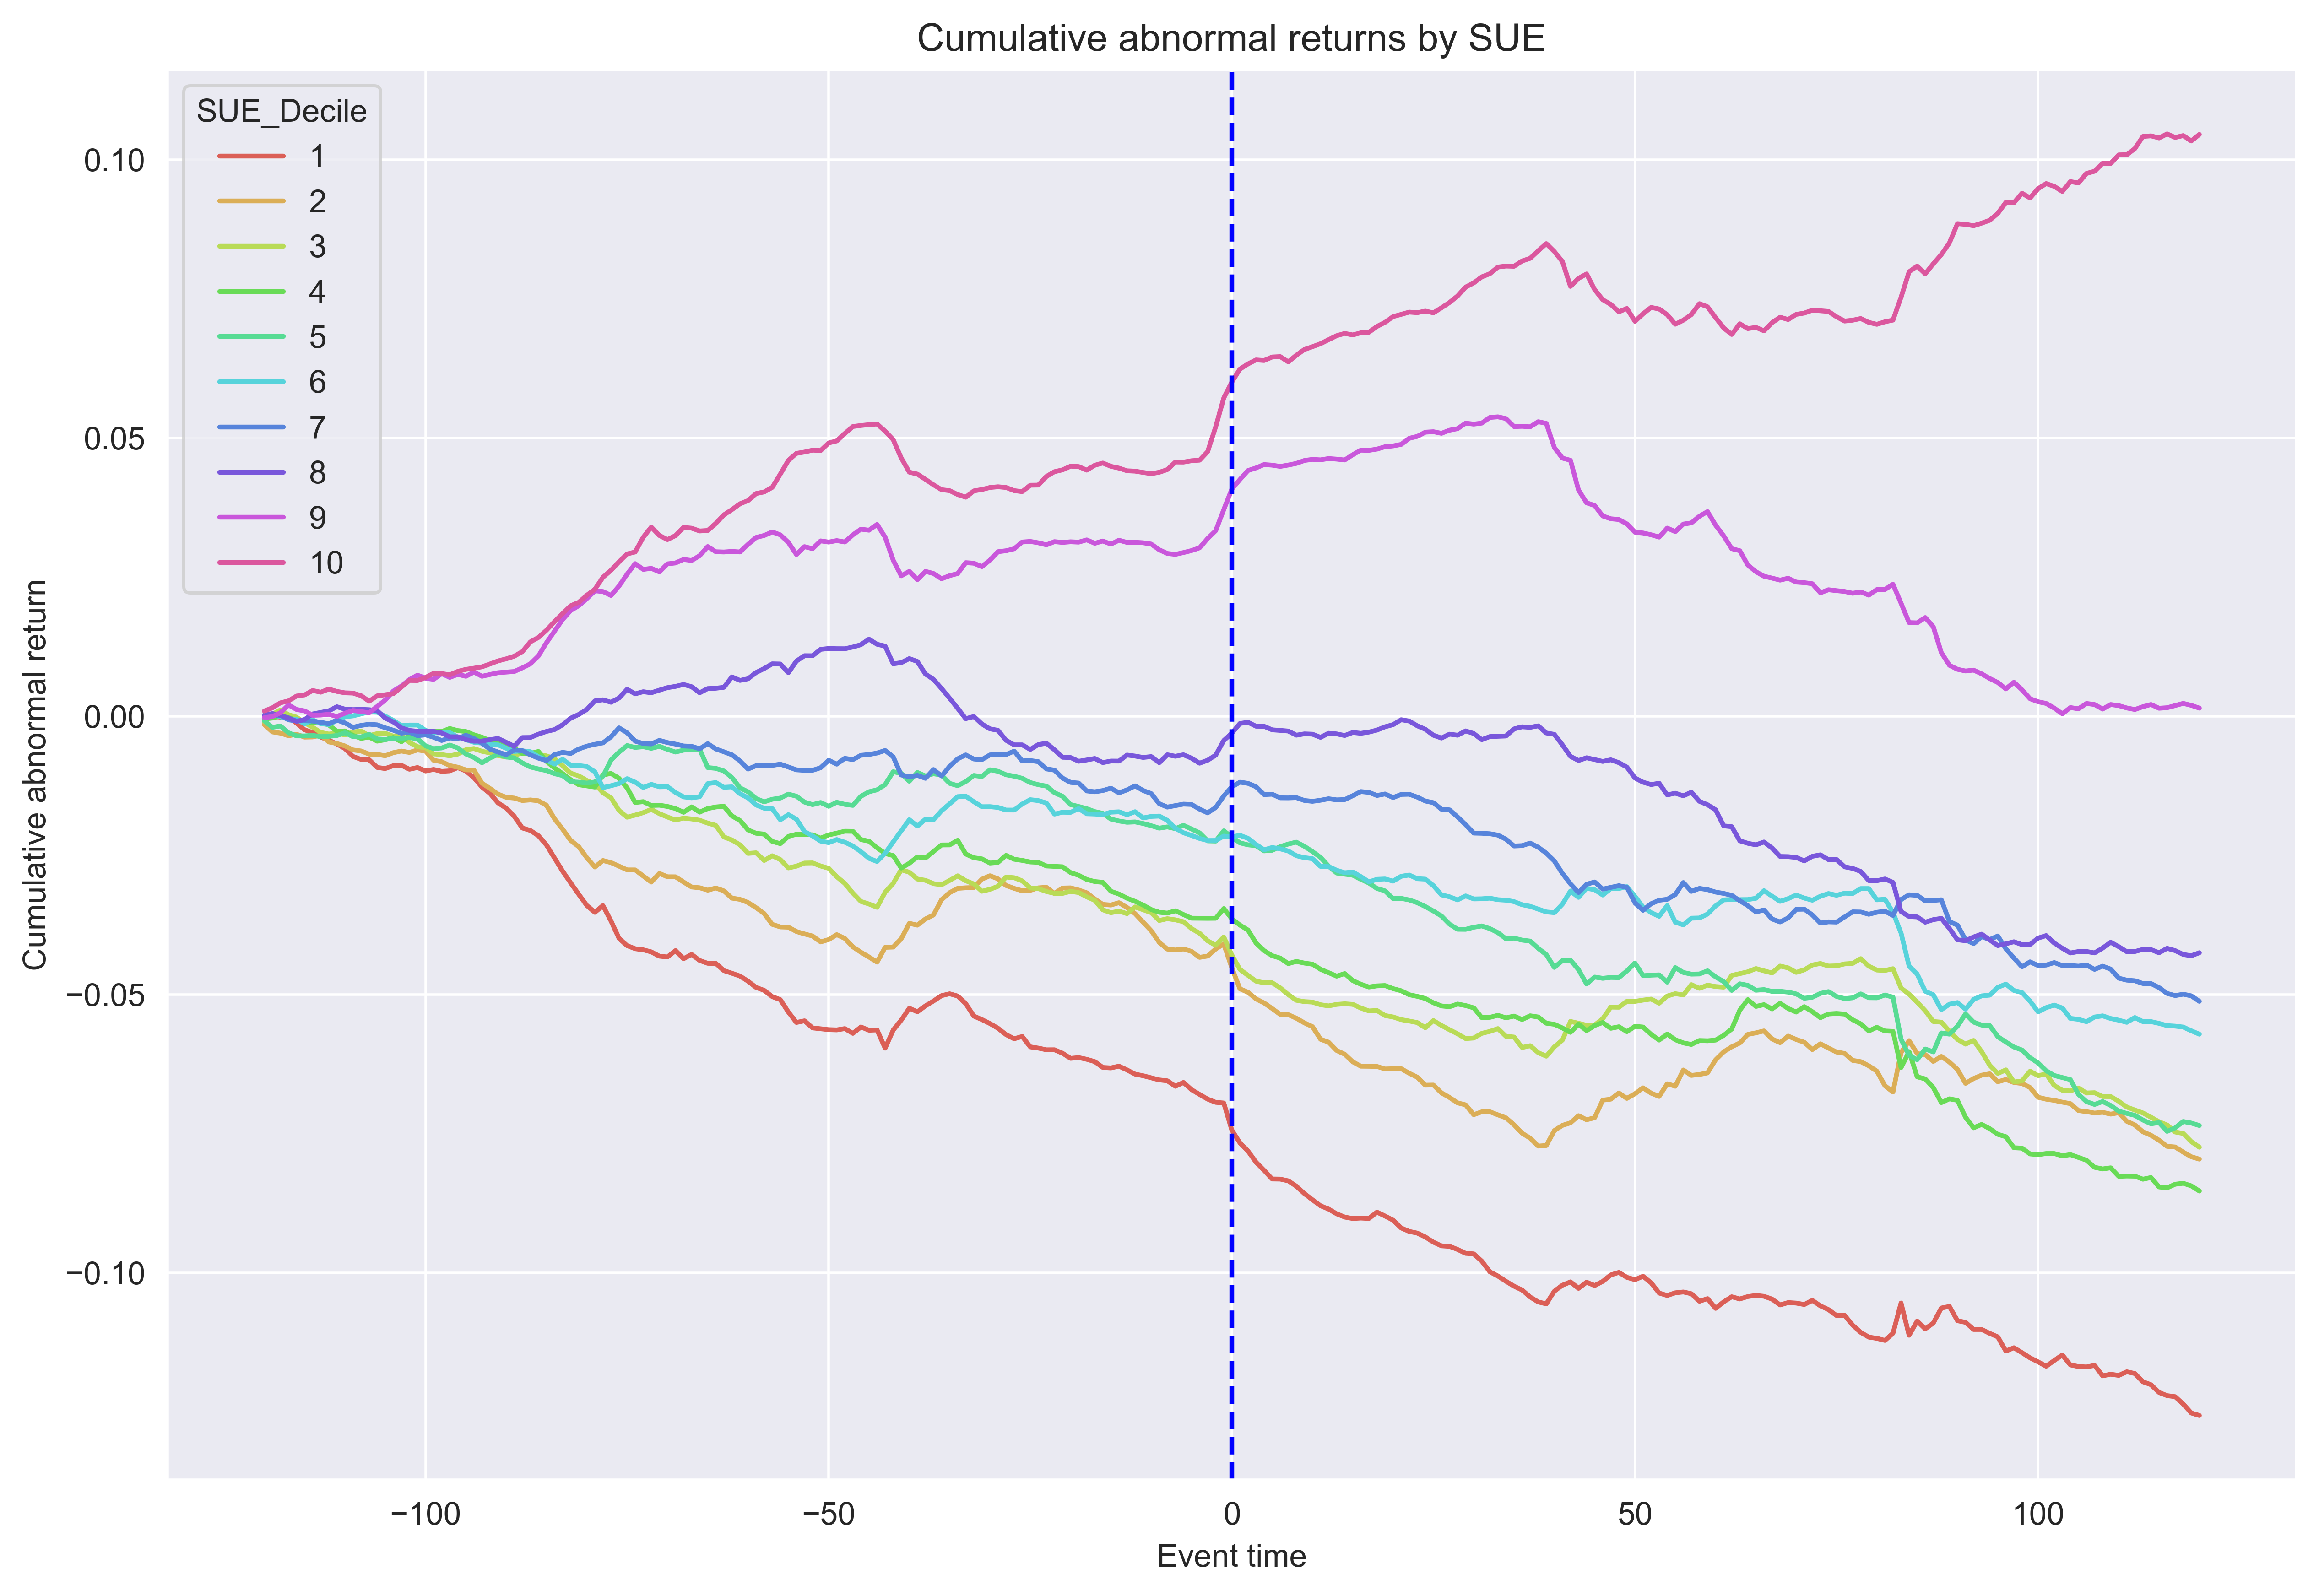

In [35]:
plt.figure(figsize = (12,8), dpi = 500)
custom_palette = sns.color_palette("hls", 10)
sns.set_style("darkgrid")
sns.lineplot(data = df_CAR_Group, x = 'event_time', y = 'CAR', hue = 'SUE_Decile', palette = custom_palette)
plt.axvline(0, color = 'blue',linestyle = '--')
plt.xlabel('Event time')
plt.ylabel('Cumulative abnormal return')
plt.title('Cumulative abnormal returns by SUE')
plt.show()

## 4. Acknowledgement
- Thanks for ***Professor Jinfan ZHANG*** and ***Teaching Assistants*** for designing this assignment.
- Thanks for ***Teaching Assistants*** and ***Undergraduate Student Teaching Fellows*** for reviewing and grading this submission.

Thank you so much!